In [102]:
%%capture
!pip install cvxpy pennylane

In [27]:
import numpy as np
import cvxpy as cp
import scipy as sc
import pennylane as qml
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.optim as optim
from torch.autograd import Variable

### Original PennyLane implementation

In [39]:
# quantum circuit settings
num_wires = 4
num_layers = 3
num_shots = 1
num_of_samples = 100

# dimension of the system
N = 4

# initiate the quantum device
device = qml.device("default.qubit", wires=num_wires, shots=num_of_samples)

# initialize the parameters of a unitary that we will apply
# to rho and sigma
# For the case of von neumann entropy, sigma is maximally mixed state.
# Therefore, for that, we can just use a uniform number generator for sampling

@qml.qnode(device)
def measure_rho(param):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.PauliZ(wires=0)
    qml.PauliX(wires=0)
    qml.PauliY(wires=1)

    # Apply the parameterized unitary to it
    qml.RandomLayers(param, wires=[0, 1])
    # return qml.density_matrix(wires=[0, 1])

    # measure in the computational basis
    result = qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
    return result

# maximally mixed state
sigma = np.eye(N)/N

In [37]:
np.random.seed(42)
param_init = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))
rho_test = measure_rho(param_init)
print(rho_test)

(array([ 1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,
       -1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1.,  1.,
        1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,
        1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,
       -1., -1.,  1., -1., -1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,
        1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1., -1., -1.,  1., -1.,
        1.,  1., -1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
        1., -1.,  1.,  1., -1.,  1., -1., -1., -1.]), array([ 1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
       -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1.,
        1., -1.,  1., -1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1., -1., -1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,
        1

In [35]:
@qml.qnode(device)
def measure_rho(param):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.PauliZ(wires=0)
    qml.PauliX(wires=0)
    qml.PauliY(wires=1)
    qml.RY(param[0][0], wires=0)
    qml.RX(param[0][1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RZ(param[0][2], wires=1)
    qml.CNOT(wires=[1, 0])
    qml.RX(param[1][0], wires=1)
    qml.RY(param[1][1], wires=1)
    qml.RY(param[1][2], wires=0)
    qml.RZ(param[2][0], wires=0)
    qml.RZ(param[2][1], wires=1)
    qml.RZ(param[2][2], wires=0)

    # measure in the computational basis
    result = qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
    return result

In [38]:
np.random.seed(42)
param_init = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))
rho_test = measure_rho(param_init)
print(rho_test)

(array([-1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,
       -1., -1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,
       -1., -1.,  1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,
       -1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.,  1.,
       -1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
        1., -1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,  1., -1.,
       -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,
       -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.]), array([ 1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,
        1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1.,
        1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,
       -1.,  1., -1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1.,
       -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,
        1

In [ ]:
# Evaluate von Neumann entropy using its analytical forumla

# ignore the division by zero
np.seterr(divide = 'ignore')

# quantum relative entropy
H_rho = np.real(np.trace(rho_test @ (sc.linalg.logm(rho_test) - sc.linalg.logm(sigma))))

np.seterr(divide = 'warn')

# print the result
print(np.log(N)-H_rho)

In [40]:
class neural_function(nn.Module):
    def __init__(self,dimension,hidden_layer):
        super(neural_function, self).__init__()

        self.dimension = dimension
        self.hidden_layer = hidden_layer
        self.lin1 = nn.Linear(self.dimension, self.hidden_layer)
        self.lin_end = nn.Linear(self.hidden_layer, 1)

    def forward(self, input):
        y = torch.sigmoid(self.lin1(input.float()))
        y = self.lin_end(y)

        return y

In [41]:
#@title Optimization using Gradient Descent (with neural network)

# parameters of the optimization
num_of_epochs = 1000
learning_rate = 0.05
num_of_samples = 100
dimension = 2
hidden_layer = 10

np.random.seed(42)

# initialize the neural network and quantum circuit parameters
neural_fn = neural_function(dimension, hidden_layer)
param_init = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))

# intialize the cost function store
cost_func_store = []

# start the training
for epoch in range(1, num_of_epochs):

  # evaluate the gradient with respect to the quantum circuit parameters
    gradients = np.zeros_like((param_init))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):

      # copy the parameters
            shifted = param_init.copy()

      # right shift the parameters
            shifted[i, j] += np.pi/2

      # forward evaluation
            forward_sum = 0
            result = measure_rho(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[0][sample], result[1][sample]])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                forward_sum += nn_result[0].detach().numpy()

      # normalize the forward sum
            forward_sum = forward_sum/num_of_samples

      # left shift the parameters
            shifted[i, j] -= np.pi

      # backward evaluation
            backward_sum = 0
            result = measure_rho(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[0][sample], result[1][sample]])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                backward_sum += nn_result[0].detach().numpy()

      # normalize the backward sum
            backward_sum = backward_sum/num_of_samples
      #print(backward_sum)

      # parameter-shift rule
            gradients[i, j] = - 0.5 * (forward_sum - backward_sum)

  # first copy the quantum circuit parameters before updating it
    prev_param_init = param_init.copy()

  # update the quantum circuit parameters
    param_init -= learning_rate*gradients

  # evaluate the gradient with respect to the NN parameters

  # evaluate the first term
    grad_w1 = torch.zeros_like(neural_fn.lin1.weight)
    grad_b1 = torch.zeros_like(neural_fn.lin1.bias)
    grad_w2 = torch.zeros_like(neural_fn.lin_end.weight)
    grad_b2 = torch.zeros_like(neural_fn.lin_end.bias)

    result = measure_rho(prev_param_init)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        nn_result.backward()
        grad_w1 += neural_fn.lin1.weight.grad*(1/num_of_samples)
        grad_b1 += neural_fn.lin1.bias.grad*(1/num_of_samples)
        grad_w2 += neural_fn.lin_end.weight.grad*(1/num_of_samples)
        grad_b2 += neural_fn.lin_end.bias.grad*(1/num_of_samples)
        neural_fn.lin1.weight.grad.zero_()
        neural_fn.lin1.bias.grad.zero_()
        neural_fn.lin_end.weight.grad.zero_()
        neural_fn.lin_end.bias.grad.zero_()

  # evaluate the second term
    grad_w1_2 = torch.zeros_like(neural_fn.lin1.weight.grad)
    grad_b1_2 = torch.zeros_like(neural_fn.lin1.bias.grad)
    grad_w2_2 = torch.zeros_like(neural_fn.lin_end.weight.grad)
    grad_b2_2 = torch.zeros_like(neural_fn.lin_end.bias.grad)

    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=2)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        nn_result.backward()
        grad_w1_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin1.weight.grad*(1/num_of_samples)
        grad_b1_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin1.bias.grad*(1/num_of_samples)
        grad_w2_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin_end.weight.grad*(1/num_of_samples)
        grad_b2_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin_end.bias.grad*(1/num_of_samples)
        neural_fn.lin1.weight.grad.zero_()
        neural_fn.lin1.bias.grad.zero_()
        neural_fn.lin_end.weight.grad.zero_()
        neural_fn.lin_end.bias.grad.zero_()

  # evaluate the difference, i.e., the gradient

    nn_grad_W1 = grad_w1_2 - grad_w1
    nn_grad_b1 = grad_b1_2 - grad_b1
    nn_grad_W2 = grad_w2_2 - grad_w2
    nn_grad_b2 = grad_b2_2 - grad_b2

  # update the NN weights and normalize them
    with torch.no_grad():
        neural_fn.lin1.weight -= learning_rate*nn_grad_W1
        neural_fn.lin1.bias -= learning_rate*nn_grad_b1
        neural_fn.lin_end.weight -= learning_rate*nn_grad_W2
        neural_fn.lin_end.bias -= learning_rate*nn_grad_b2

  # evaluate the cost function at these parameters
    first_term = 0
    result = measure_rho(param_init)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        first_term += nn_result[0].detach().numpy()

  # normalize the cost sum
    first_term = first_term/num_of_samples

  # # Second term evaluation
    second_term = 0
    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=2)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        second_term += np.exp(nn_result[0].detach().numpy())

  # normalize the second term sum
    second_term = second_term/num_of_samples

    # add the cost function to the store
    cost_func_store.append(np.log(N) - first_term + second_term - 1)

  # print the cost
    print(np.log(N) - first_term + second_term - 1)

1.41766390583458
1.4083090964609628
1.3829508636051657
1.3760499153191095
1.3856036087030414
1.3921234837824348
1.3903248999172693
1.3813722980672365
1.3730747961157803
1.377251307433272
1.3932523570114617
1.3751197380477431
1.3835309471839907
1.4097603332156186
1.400547246103907
1.3793179166966918
1.3800481528693682
1.3848078318590167
1.382558588152552
1.3673338688069823
1.3708840451294426
1.3920283885950093
1.3533659406656269
1.3961105441206936
1.3964416215473658
1.3724602290147785
1.395418312018538
1.3737460561746602
1.3814802472943306
1.3681224282735829
1.380760165219927
1.3953460921997074
1.375856254463816
1.3826487106734753
1.3773303533250334
1.3711584410721307
1.37668320841136
1.3768775045031552
1.3619425486678125
1.3552826835865024
1.3712507567459586
1.3713227910453325
1.3781527302319052
1.3885771448070052
1.3835462608093265
1.4088530497902871
1.375643307631636
1.3923099935704712
1.372531114434624
1.3889954204017165
1.359550805305863
1.369388929074431
1.3784022345298772
1.37713

In [ ]:
#@title Optimization using Gradient Descent (with neural network)

# parameters of the optimization
num_of_epochs = 1000
learning_rate = 0.05
num_of_samples = 100
dimension = 2
hidden_layer = 10

# initialize the neural network and quantum circuit parameters
neural_fn = neural_function(dimension, hidden_layer)
param_init = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))

# intialize the cost function store
cost_func_store = []

# start the training
for epoch in range(1, num_of_epochs):

  # evaluate the gradient with respect to the quantum circuit parameters
    gradients = np.zeros_like((param_init))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):

      # copy the parameters
            shifted = param_init.copy()

      # right shift the parameters
            shifted[i, j] += np.pi/2

      # forward evaluation
            forward_sum = 0
            result = measure_rho(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[0][sample], result[1][sample]])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                forward_sum += nn_result[0].detach().numpy()

      # normalize the forward sum
            forward_sum = forward_sum/num_of_samples

      # left shift the parameters
            shifted[i, j] -= np.pi

      # backward evaluation
            backward_sum = 0
            result = measure_rho(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[0][sample], result[1][sample]])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                backward_sum += nn_result[0].detach().numpy()

      # normalize the backward sum
            backward_sum = backward_sum/num_of_samples
      #print(backward_sum)

      # parameter-shift rule
            gradients[i, j] = - 0.5 * (forward_sum - backward_sum)

  # first copy the quantum circuit parameters before updating it
    prev_param_init = param_init.copy()

  # update the quantum circuit parameters
    param_init -= learning_rate*gradients

  # evaluate the gradient with respect to the NN parameters

  # evaluate the first term
    grad_w1 = torch.zeros_like(neural_fn.lin1.weight)
    grad_b1 = torch.zeros_like(neural_fn.lin1.bias)
    grad_w2 = torch.zeros_like(neural_fn.lin_end.weight)
    grad_b2 = torch.zeros_like(neural_fn.lin_end.bias)

    result = measure_rho(prev_param_init)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        nn_result.backward()
        grad_w1 += neural_fn.lin1.weight.grad*(1/num_of_samples)
        grad_b1 += neural_fn.lin1.bias.grad*(1/num_of_samples)
        grad_w2 += neural_fn.lin_end.weight.grad*(1/num_of_samples)
        grad_b2 += neural_fn.lin_end.bias.grad*(1/num_of_samples)
        neural_fn.lin1.weight.grad.zero_()
        neural_fn.lin1.bias.grad.zero_()
        neural_fn.lin_end.weight.grad.zero_()
        neural_fn.lin_end.bias.grad.zero_()

  # evaluate the second term
    grad_w1_2 = torch.zeros_like(neural_fn.lin1.weight.grad)
    grad_b1_2 = torch.zeros_like(neural_fn.lin1.bias.grad)
    grad_w2_2 = torch.zeros_like(neural_fn.lin_end.weight.grad)
    grad_b2_2 = torch.zeros_like(neural_fn.lin_end.bias.grad)

    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=2)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        nn_result.backward()
        grad_w1_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin1.weight.grad*(1/num_of_samples)
        grad_b1_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin1.bias.grad*(1/num_of_samples)
        grad_w2_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin_end.weight.grad*(1/num_of_samples)
        grad_b2_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin_end.bias.grad*(1/num_of_samples)
        neural_fn.lin1.weight.grad.zero_()
        neural_fn.lin1.bias.grad.zero_()
        neural_fn.lin_end.weight.grad.zero_()
        neural_fn.lin_end.bias.grad.zero_()

  # evaluate the difference, i.e., the gradient

    nn_grad_W1 = grad_w1_2 - grad_w1
    nn_grad_b1 = grad_b1_2 - grad_b1
    nn_grad_W2 = grad_w2_2 - grad_w2
    nn_grad_b2 = grad_b2_2 - grad_b2

  # update the NN weights and normalize them
    with torch.no_grad():
        neural_fn.lin1.weight -= learning_rate*nn_grad_W1
        neural_fn.lin1.bias -= learning_rate*nn_grad_b1
        neural_fn.lin_end.weight -= learning_rate*nn_grad_W2
        neural_fn.lin_end.bias -= learning_rate*nn_grad_b2

  # evaluate the cost function at these parameters
    first_term = 0
    result = measure_rho(param_init)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        first_term += nn_result[0].detach().numpy()

  # normalize the cost sum
    first_term = first_term/num_of_samples

  # # Second term evaluation
    second_term = 0
    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=2)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        second_term += np.exp(nn_result[0].detach().numpy())

  # normalize the second term sum
    second_term = second_term/num_of_samples

    # add the cost function to the store
    cost_func_store.append(np.log(N) - first_term + second_term - 1)

  # print the cost
    print(np.log(N) - first_term + second_term - 1)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd # import the pandas library

plt.plot(cost_func_store, label = "Cost function")
plt.plot(pd.Series(cost_func_store).rolling(window=10).mean(), label = "Moving average") # Call Series from the pandas library
plt.axhline(0.69, color='black')

In [ ]:
#@title Optimization using Gradient Descent (without neural network)

# parameters of the optimization
num_of_epochs = 1000
learning_rate = 0.08
num_of_samples = 100
deviation = 1

# initialize the neural network and quantum circuit parameters
W = deviation*np.random.rand(3,3)
np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))

# intialize the cost function store
cost_func_store = []


# start the training
for epoch in range(1, num_of_epochs):

  # evaluate the gradient with respect to the quantum circuit parameters
    gradients = np.zeros_like((param_init))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):

      # copy the parameters
            shifted = param_init.copy()

      # right shift the parameters
            shifted[i, j] += np.pi/2

      # forward evaluation
            forward_sum = 0
            result = measure_rho(shifted)
            for sample in range(num_of_samples):
                forward_sum += W[result[0][sample]][result[1][sample]]

      # normalize the forward sum
            forward_sum = forward_sum/num_of_samples

      # left shift the parameters
            shifted[i, j] -= np.pi

      # backward evaluation
            backward_sum = 0
            result = measure_rho(shifted)
            for sample in range(num_of_samples):
                backward_sum += W[result[0][sample]][result[1][sample]]

      # normalize the backward sum
            backward_sum = backward_sum/num_of_samples
      #print(backward_sum)

      # parameter-shift rule
            gradients[i, j] = - 0.5 * (forward_sum - backward_sum)

  # first copy the quantum circuit parameters before updating it
    prev_param_init = param_init.copy()

  # update the quantum circuit parameters
    param_init -= learning_rate*gradients

  # evaluate the gradient with respect to the NN parameters


  # evaluate the gradient with respect to the eigenvalues

  # 1 , 1
    E = np.zeros_like(W)
    E[1][1] = 1
    dW1 = 0
    result = measure_rho(prev_param_init)
    for sample in range(num_of_samples):
        dW1 -= E[result[0][sample]][result[1][sample]]


    # normalize it
    dW1 = dW1/num_of_samples
    dW1 += (np.exp(W[1][1])/N)

    # 1 , -1
    E = np.zeros_like(W)
    E[1][-1] = 1
    dW2 = 0
    result = measure_rho(prev_param_init)
    for sample in range(num_of_samples):
        dW2 -= E[result[0][sample]][result[1][sample]]


    # normalize it
    dW2 = dW2/num_of_samples
    dW2 += (np.exp(W[1][-1])/N)

    # -1 , 1
    E = np.zeros_like(W)
    E[-1][1] = 1
    dW3 = 0
    result = measure_rho(prev_param_init)
    for sample in range(num_of_samples):
        dW3 -= E[result[0][sample]][result[1][sample]]


    # normalize it
    dW3 = dW3/num_of_samples
    dW3 += (np.exp(W[-1][1])/N)

    # -1 , -1
    E = np.zeros_like(W)
    E[-1][-1] = 1
    dW4 = 0
    result = measure_rho(prev_param_init)
    for sample in range(num_of_samples):
        dW4 -= E[result[0][sample]][result[1][sample]]


    # normalize it
    dW4 = dW4/num_of_samples
    dW4 += (np.exp(W[-1][-1])/N)


    # update the eigenvalues
    W[1][1] -= learning_rate*dW1
    W[1][-1] -= learning_rate*dW2
    W[-1][1] -= learning_rate*dW3
    W[-1][-1] -= learning_rate*dW4

    # evaluate the cost function at these parameters
    first_term = 0
    result = measure_rho(param_init)
    for sample in range(num_of_samples):
        first_term += W[result[0][sample]][result[1][sample]]

    # normalize the cost sum
    first_term = first_term/num_of_samples

    # # Second term evaluation
    second_term = np.exp(W[1][1]) + np.exp(W[1][-1]) + np.exp(W[-1][1]) + np.exp(W[-1][-1])

    # normalize the second term sum
    second_term = second_term/N

    # add the cost function to the store
    cost_func_store.append(np.log(N) - first_term + second_term - 1)

    # print the cost
    print(np.log(N) - first_term + second_term - 1)

### Qiskit Implementation

In [1]:
%%capture
%matplotlib inline

!pip install qiskit qiskit-aer pylatexenc pandas

In [1]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.circuit import Parameter
from qiskit.quantum_info import random_unitary
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import DensityMatrix, partial_trace
from qiskit_aer import AerSimulator
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.optim as optim
from torch.autograd import Variable
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Measurement results for PauliZ(0): [0 1 0 1 0 1 0 1]
Measurement results for PauliZ(1): [0 0 1 1 0 0 1 1]
Reduced density matrix after tracing out qubits 2 and 3:
 DensityMatrix([[ 0.37357785+0.j        ,  0.03475019-0.08493802j,
                 0.15519525-0.03044427j,  0.02271595-0.11523037j],
               [ 0.03475019+0.08493802j,  0.12642215+0.j        ,
                 0.06456611+0.09810846j, -0.15519525+0.03044427j],
               [ 0.15519525+0.03044427j,  0.06456611-0.09810846j,
                 0.12642215+0.j        , -0.03475019+0.08493802j],
               [ 0.02271595+0.11523037j, -0.15519525-0.03044427j,
                -0.03475019-0.08493802j,  0.37357785+0.j        ]],
              dims=(2, 2))


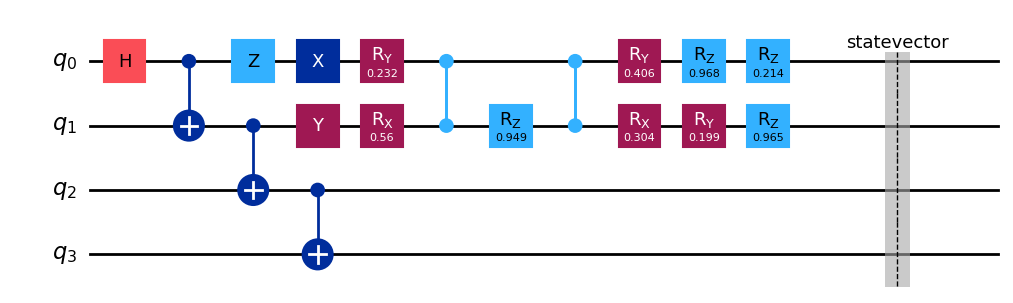

In [10]:
num_wires = 4
num_layers = 3
num_shots = 100
num_rotations = 3

# Dimension of the system
N = 4

simulator = AerSimulator(method='statevector')

qc = QuantumCircuit(num_wires)

qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.z(0)
qc.x(0)
qc.y(1)

param = np.random.random((num_layers, num_rotations))

parameters = [[Parameter(f'θ_{layer}_{rot}') for rot in range(num_rotations)] for layer in range(num_layers)]

qc.ry(parameters[0][0], 0)
qc.rx(parameters[0][1], 1)
qc.cz(0, 1)
qc.rz(parameters[0][2], 1)
qc.cz(1, 0)
qc.rx(parameters[1][0], 1)
qc.ry(parameters[1][1], 1)
qc.ry(parameters[1][2], 0)
qc.rz(parameters[2][0], 0)  
qc.rz(parameters[2][1], 1)
qc.rz(parameters[2][2], 0)

param_dict = {parameters[layer][rot]: param[layer][rot] for layer in range(num_layers) for rot in range(num_rotations)}
qc = qc.assign_parameters(param_dict)

qc.save_statevector()

# Transpile and run the quantum circuit
tqc = transpile(qc, simulator)
job = simulator.run(tqc, shots=num_shots)
result = job.result()
state_vector = result.get_statevector()
counts = result.get_counts(tqc)

z0_samples = np.array([int(bit[3]) for bit in counts.keys()])
z1_samples = np.array([int(bit[2]) for bit in counts.keys()])

print("Measurement results for PauliZ(0):", z0_samples)
print("Measurement results for PauliZ(1):", z1_samples)

# Obtain the density matrix and perform partial trace over qubits 2 and 3
density_matrix = DensityMatrix(state_vector)
rho_test = partial_trace(density_matrix, [2, 3])

print("Reduced density matrix after tracing out qubits 2 and 3:\n", rho_test)

# Visualize the quantum circuit
qc.draw('mpl')

In [11]:
# param -> density matrix

def measure_rho(param):

    num_wires = 4
    num_layers = 3
    num_shots = 100
    num_rotations = 3

    # check the size of the parameter
    assert param.shape == (num_layers, num_rotations)
    simulator = AerSimulator(method='statevector')

    qc = QuantumCircuit(num_wires)

    qc.h(0)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.cx(2, 3)
    qc.z(0)
    qc.x(0)
    qc.y(1)

    parameters = [[Parameter(f'θ_{layer}_{rot}') for rot in range(num_rotations)] for layer in range(num_layers)]
    param_dict = {parameters[layer][rot]: param[layer][rot] for layer in range(num_layers) for rot in range(num_rotations)}

    qc.ry(parameters[0][0], 0)
    qc.rx(parameters[0][1], 1)
    qc.cz(0, 1)
    qc.rz(parameters[0][2], 1)
    qc.cz(1, 0)
    qc.rx(parameters[1][0], 1)
    qc.ry(parameters[1][1], 1)
    qc.ry(parameters[1][2], 0)
    qc.rz(parameters[2][0], 0)  
    qc.rz(parameters[2][1], 1)
    qc.rz(parameters[2][2], 0)

    qc = qc.assign_parameters(param_dict)

    qc.save_statevector()

    tqc = transpile(qc, simulator)
    job = simulator.run(tqc, shots=num_shots)
    result = job.result()
    state_vector = result.get_statevector()

    density_matrix = DensityMatrix(state_vector)
    density_matrix = partial_trace(density_matrix, [2, 3])
    return np.array(density_matrix)

def measure_qc(param):
    num_wires = 4
    num_layers = 3
    num_shots = 100
    num_rotations = 3

    # check the size of the parameter
    assert param.shape == (num_layers, num_rotations)
    simulator = AerSimulator(method='statevector')

    qc = QuantumCircuit(num_wires)

    qc.h(0)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.cx(2, 3)
    qc.z(0)
    qc.x(0)
    qc.y(1)

    parameters = [[Parameter(f'θ_{layer}_{rot}') for rot in range(num_rotations)] for layer in range(num_layers)]
    param_dict = {parameters[layer][rot]: param[layer][rot] for layer in range(num_layers) for rot in range(num_rotations)}

    qc.ry(parameters[0][0], 0)
    qc.rx(parameters[0][1], 1)
    qc.cz(0, 1)
    qc.rz(parameters[0][2], 1)
    qc.cz(1, 0)
    qc.rx(parameters[1][0], 1)
    qc.ry(parameters[1][1], 1)
    qc.ry(parameters[1][2], 0)
    qc.rz(parameters[2][0], 0)  
    qc.rz(parameters[2][1], 1)
    qc.rz(parameters[2][2], 0)

    qc = qc.assign_parameters(param_dict)
    qc.measure_all()

    # Transpile and run the quantum circuit
    tqc = transpile(qc, simulator)
    job = simulator.run(tqc, shots=num_shots)
    result = job.result()
    counts = result.get_counts(tqc)

    # Process the measurement results (equivalent to qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1)))
    z0_samples = []
    z1_samples = []

    for bitstring, count in counts.items():
        z0 = int(bitstring[-1])  # Extracting the measurement result of qubit 0
        z1 = int(bitstring[-2])  # Extracting the measurement result of qubit 1
        z0_samples.extend([z0] * count)  # Append the result 'count' times
        z1_samples.extend([z1] * count)  # Append the result 'count' times
        
    return z0_samples, z1_samples

In [12]:
# test two function

param = np.random.random((num_layers, num_rotations))
rho_test = measure_rho(param)
z0_samples, z1_samples = measure_qc(param)

print("Density matrix:\n", rho_test)
print("Measurement results for PauliZ(0):", z0_samples)
print("Measurement results for PauliZ(1):", z1_samples)

Density matrix:
 [[ 0.23172273+0.j          0.00211023+0.01522284j  0.13584408+0.133513j
   0.09551674-0.12855727j]
 [ 0.00211023-0.01522284j  0.26827727+0.j         -0.12688489+0.09772739j
  -0.13584408-0.133513j  ]
 [ 0.13584408-0.133513j   -0.12688489-0.09772739j  0.26827727+0.j
  -0.00211023-0.01522284j]
 [ 0.09551674+0.12855727j -0.13584408+0.133513j   -0.00211023+0.01522284j
   0.23172273+0.j        ]]
Measurement results for PauliZ(0): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
Measurement results for PauliZ(1): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [13]:
import scipy.linalg as la
# Evaluate von Neumann entropy using its analytical forumla

# ignore the division by zero
np.seterr(divide = 'ignore')

# maximally mixed state
sigma = np.eye(N)/N

# quantum relative entropy
H_rho = np.real(np.trace(rho_test @ (la.logm(rho_test) - la.logm(sigma))))

np.seterr(divide = 'warn')

# print the result
print(np.log(N)-H_rho)

0.6931471805599458


In [14]:
class neural_function(nn.Module):
    def __init__(self,dimension,hidden_layer):
        super(neural_function, self).__init__()

        self.dimension = dimension
        self.hidden_layer = hidden_layer
        self.lin1 = nn.Linear(self.dimension, self.hidden_layer)
        self.lin_end = nn.Linear(self.hidden_layer, 1)

    def forward(self, input):
        y = torch.sigmoid(self.lin1(input.float()))
        y = self.lin_end(y)

        return y

In [15]:
#@title Optimization using Gradient Descent (with neural network)
import json

# parameters of the optimization
num_of_epochs = 500
learning_rate = 0.05
num_of_samples = 100
dimension = 2
hidden_layer = 10

# initialize the neural network and quantum circuit parameters
neural_fn = neural_function(dimension, hidden_layer)

# intialize the cost function store
cost_func_store = []
gradients_store = []

# Quantum circuit parameters
param_init = np.random.random(size=(num_layers, 3))

# Qiskit simulator backend
simulator = AerSimulator(method='statevector')

# Training loop
for epoch in range(1, num_of_epochs + 1):
  # evaluate the gradient with respect to the quantum circuit parameters
    gradients = np.zeros_like((param_init))
    
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):

      # copy the parameters
            shifted = param_init.copy()

      # right shift the parameters
            shifted[i, j] += np.pi/2

      # forward evaluation
            forward_sum = 0
            result = measure_qc(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[0][sample], result[1][sample]])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                forward_sum += nn_result[0].detach().numpy()

      # normalize the forward sum
            forward_sum = forward_sum/num_of_samples

      # left shift the parameters
            shifted[i, j] -= np.pi

      # backward evaluation
            backward_sum = 0
            result = measure_qc(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[0][sample], result[1][sample]])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                backward_sum += nn_result[0].detach().numpy()

      # normalize the backward sum
            backward_sum = backward_sum/num_of_samples
      #print(backward_sum)

      # parameter-shift rule
            gradients[i, j] = - 0.5 * (forward_sum - backward_sum)

  # first copy the quantum circuit parameters before updating it
    prev_param_init = param_init.copy()

  # update the quantum circuit parameters
    param_init -= learning_rate*gradients

    gradients_store.append(gradients)

  # evaluate the gradient with respect to the NN parameters

  # evaluate the first term
    grad_w1 = torch.zeros_like(neural_fn.lin1.weight)
    grad_b1 = torch.zeros_like(neural_fn.lin1.bias)
    grad_w2 = torch.zeros_like(neural_fn.lin_end.weight)
    grad_b2 = torch.zeros_like(neural_fn.lin_end.bias)

    result = measure_qc(prev_param_init)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        nn_result.backward()
        grad_w1 += neural_fn.lin1.weight.grad*(1/num_of_samples)
        grad_b1 += neural_fn.lin1.bias.grad*(1/num_of_samples)
        grad_w2 += neural_fn.lin_end.weight.grad*(1/num_of_samples)
        grad_b2 += neural_fn.lin_end.bias.grad*(1/num_of_samples)
        neural_fn.lin1.weight.grad.zero_()
        neural_fn.lin1.bias.grad.zero_()
        neural_fn.lin_end.weight.grad.zero_()
        neural_fn.lin_end.bias.grad.zero_()

  # evaluate the second term
    grad_w1_2 = torch.zeros_like(neural_fn.lin1.weight.grad)
    grad_b1_2 = torch.zeros_like(neural_fn.lin1.bias.grad)
    grad_w2_2 = torch.zeros_like(neural_fn.lin_end.weight.grad)
    grad_b2_2 = torch.zeros_like(neural_fn.lin_end.bias.grad)

    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=2)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        nn_result.backward()
        grad_w1_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin1.weight.grad*(1/num_of_samples)
        grad_b1_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin1.bias.grad*(1/num_of_samples)
        grad_w2_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin_end.weight.grad*(1/num_of_samples)
        grad_b2_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin_end.bias.grad*(1/num_of_samples)
        neural_fn.lin1.weight.grad.zero_()
        neural_fn.lin1.bias.grad.zero_()
        neural_fn.lin_end.weight.grad.zero_()
        neural_fn.lin_end.bias.grad.zero_()

  # evaluate the difference, i.e., the gradient

    nn_grad_W1 = grad_w1_2 - grad_w1
    nn_grad_b1 = grad_b1_2 - grad_b1
    nn_grad_W2 = grad_w2_2 - grad_w2
    nn_grad_b2 = grad_b2_2 - grad_b2

  # update the NN weights and normalize them
    with torch.no_grad():
        neural_fn.lin1.weight -= learning_rate*nn_grad_W1
        neural_fn.lin1.bias -= learning_rate*nn_grad_b1
        neural_fn.lin_end.weight -= learning_rate*nn_grad_W2
        neural_fn.lin_end.bias -= learning_rate*nn_grad_b2

  # evaluate the cost function at these parameters
    first_term = 0
    result = measure_qc(param_init)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        first_term += nn_result[0].detach().numpy()

  # normalize the cost sum
    first_term = first_term/num_of_samples

  # # Second term evaluation
    second_term = 0
    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=2)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        second_term += np.exp(nn_result[0].detach().numpy())

  # normalize the second term sum
    second_term = second_term/num_of_samples

    cost_func = np.log(N) - first_term + second_term - 1

    # add the cost function to the store
    cost_func_store.append(cost_func)

    # with open(f'vn_net_param/neural_fn_params_epoch{epoch}.json', 'w') as f:
    #  json.dump(neural_fn.state_dict(), f, default=lambda x: x.tolist())

  # print the cost
    print(f"epoch: {epoch}, cost: {cost_func}")

epoch: 1, cost: 1.3994101122671605
epoch: 2, cost: 1.388074324345017
epoch: 3, cost: 1.3871324299180747
epoch: 4, cost: 1.3682311458045486
epoch: 5, cost: 1.376924472739721
epoch: 6, cost: 1.3638872907215598
epoch: 7, cost: 1.3604558166021352
epoch: 8, cost: 1.3597071624452117
epoch: 9, cost: 1.3550998354608064
epoch: 10, cost: 1.3388573045933487
epoch: 11, cost: 1.3463470208549744
epoch: 12, cost: 1.3479620364213232
epoch: 13, cost: 1.3487185372317079
epoch: 14, cost: 1.3375478193068746
epoch: 15, cost: 1.3271094650680069
epoch: 16, cost: 1.3158749583268405
epoch: 17, cost: 1.3293010976070407
epoch: 18, cost: 1.3308365110212805
epoch: 19, cost: 1.326405356665874
epoch: 20, cost: 1.3317503810578826
epoch: 21, cost: 1.2927013277912383
epoch: 22, cost: 1.3211236306929832
epoch: 23, cost: 1.284965301817084
epoch: 24, cost: 1.3135474552119022
epoch: 25, cost: 1.3032489041143895
epoch: 26, cost: 1.296430723508621
epoch: 27, cost: 1.3034794462377075
epoch: 28, cost: 1.3150124847048765
epoch:

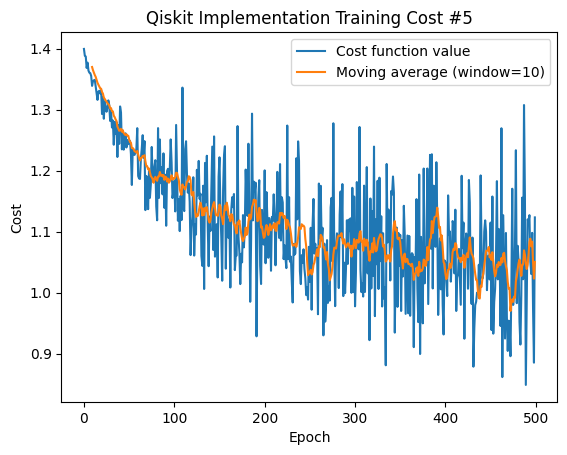

In [16]:
# cost_func_storeの可視化
plt.plot(cost_func_store, label='Cost function value')
plt.plot(pd.Series(cost_func_store).rolling(10).mean(), label='Moving average (window=10)')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Qiskit Implementation Training Cost #5')
plt.legend()
plt.show()

In [23]:
#@title Optimization using Gradient Descent (without neural network)

# parameters of the optimization
num_of_epochs = 1000
learning_rate = 0.08
num_of_samples = 100
deviation = 1

# initialize the neural network and quantum circuit parameters
W = deviation*np.random.rand(3,3)

param_init = np.random.random(size=(num_layers, 3))

# intialize the cost function store
cost_func_store = []


# start the training
for epoch in range(1, num_of_epochs):

  # evaluate the gradient with respect to the quantum circuit parameters
    gradients = np.zeros_like((param_init))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):

      # copy the parameters
            shifted = param_init.copy()

      # right shift the parameters
            shifted[i, j] += np.pi/2

      # forward evaluation
            forward_sum = 0
            result = measure_qc(shifted)
            for sample in range(num_of_samples):
                forward_sum += W[result[0][sample]][result[1][sample]]

      # normalize the forward sum
            forward_sum = forward_sum/num_of_samples

      # left shift the parameters
            shifted[i, j] -= np.pi

      # backward evaluation
            backward_sum = 0
            result = measure_qc(shifted)
            for sample in range(num_of_samples):
                backward_sum += W[result[0][sample]][result[1][sample]]

      # normalize the backward sum
            backward_sum = backward_sum/num_of_samples
      #print(backward_sum)

      # parameter-shift rule
            gradients[i, j] = - 0.5 * (forward_sum - backward_sum)

  # first copy the quantum circuit parameters before updating it
    prev_param_init = param_init.copy()

  # update the quantum circuit parameters
    param_init -= learning_rate*gradients

  # evaluate the gradient with respect to the NN parameters


  # evaluate the gradient with respect to the eigenvalues

  # 1 , 1
    E = np.zeros_like(W)
    E[1][1] = 1
    dW1 = 0
    result = measure_qc(prev_param_init)
    for sample in range(num_of_samples):
        dW1 -= E[result[0][sample]][result[1][sample]]


    # normalize it
    dW1 = dW1/num_of_samples
    dW1 += (np.exp(W[1][1])/N)

    # 1 , -1
    E = np.zeros_like(W)
    E[1][-1] = 1
    dW2 = 0
    result = measure_qc(prev_param_init)
    for sample in range(num_of_samples):
        dW2 -= E[result[0][sample]][result[1][sample]]


    # normalize it
    dW2 = dW2/num_of_samples
    dW2 += (np.exp(W[1][-1])/N)

    # -1 , 1
    E = np.zeros_like(W)
    E[-1][1] = 1
    dW3 = 0
    result = measure_qc(prev_param_init)
    for sample in range(num_of_samples):
        dW3 -= E[result[0][sample]][result[1][sample]]


    # normalize it
    dW3 = dW3/num_of_samples
    dW3 += (np.exp(W[-1][1])/N)

    # -1 , -1
    E = np.zeros_like(W)
    E[-1][-1] = 1
    dW4 = 0
    result = measure_qc(prev_param_init)
    for sample in range(num_of_samples):
        dW4 -= E[result[0][sample]][result[1][sample]]


    # normalize it
    dW4 = dW4/num_of_samples
    dW4 += (np.exp(W[-1][-1])/N)


    # update the eigenvalues
    W[1][1] -= learning_rate*dW1
    W[1][-1] -= learning_rate*dW2
    W[-1][1] -= learning_rate*dW3
    W[-1][-1] -= learning_rate*dW4

    # evaluate the cost function at these parameters
    first_term = 0
    result = measure_qc(param_init)
    for sample in range(num_of_samples):
        first_term += W[result[0][sample]][result[1][sample]]

    # normalize the cost sum
    first_term = first_term/num_of_samples

    # # Second term evaluation
    second_term = np.exp(W[1][1]) + np.exp(W[1][-1]) + np.exp(W[-1][1]) + np.exp(W[-1][-1])

    # normalize the second term sum
    second_term = second_term/N

    # add the cost function to the store
    cost_func_store.append(np.log(N) - first_term + second_term - 1)

    # print the cost
    print(f'epoch: {epoch}, cost func: {np.log(N) - first_term + second_term - 1})

1.3827580166344156
1.3816550649494923
1.3380087367421005
1.2771333711920292
1.2515337227506222
1.2343768186906536
1.2253469906986973
1.1837224264703714
1.1676333497376064
1.1347361217156724
1.136395986213758
1.0658753087986517
1.0903928382271015
1.0502792729992936
1.0111845614227315
1.0308978739093542
0.9975798380806364
0.972100787720767
0.9413827216434578
0.9337984059680504
0.9550765538134927
0.9301366999245002
0.9222838443293353
0.903032154658606
0.8722219523876724
0.852213490536398
0.8514433084545319
0.860523324810363
0.8526663709218267
0.8197517493495889
0.8531912990610997
0.8352794799300223
0.8176405583786517
0.8161364179882258
0.8010504760624066
0.7957506693588652
0.7698573770082433
0.7597789824382928
0.7268468458040112
0.7442928083160982
0.7234712721315577
0.7372170501372015
0.7191195506903185
0.7270059546481553
0.7136355547645019
0.7020148824460213
0.6835269177237762
0.7165394064926494
0.6858309732249099
0.6786844648832955
0.6689159825906721
0.6739776047096773
0.644416357965876

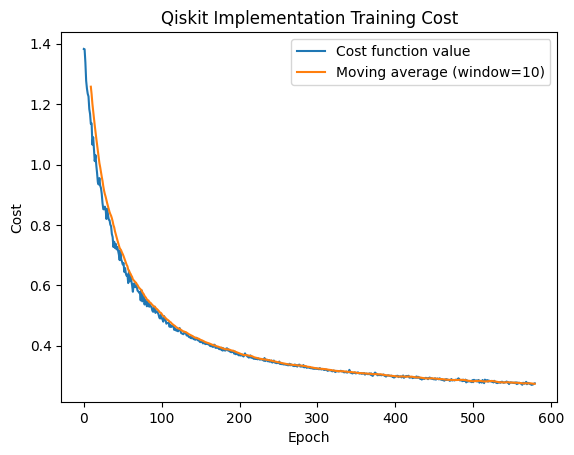

In [15]:
# cost_func_storeの可視化
plt.plot(np.array(cost_func_store), label='Cost function value')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Qiskit Implementation Training Cost')
plt.legend()
plt.show()

"""We use Pennylane’s qml.RandomLayers subroutine to prepare a parameterized quantum circuit with a random structure and then keep this structure fixed throughout multiple runs of a specific simulation. We only change the structure when it is not sufficiently expressive, in the sense that the set of generated unitaries is not comparable to the set of all unitaries. """

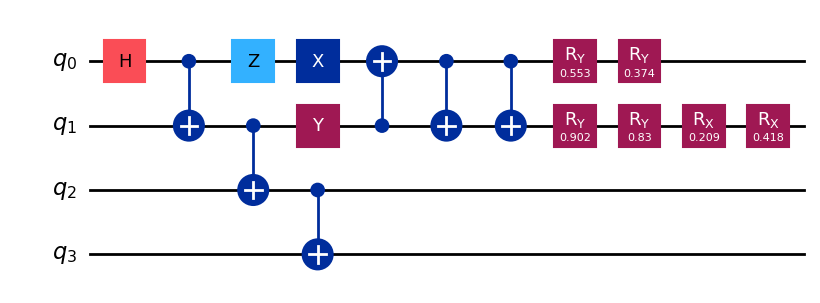

In [27]:
from qiskit.circuit.random import random_circuit

def random_layers(param, obj_wires, num_wires, ratio_imprim=0.3, imprimitive='cx', rotations=['rx', 'ry', 'rz'], seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    num_qubits = num_wires
    circuit = QuantumCircuit(num_qubits)
    shape = param.shape
    num_layers = shape[0]
    rng = np.random.default_rng(seed)

    circuit.h(0)
    circuit.cx(0, 1)
    circuit.cx(1, 2)
    circuit.cx(2, 3)
    circuit.z(0)
    circuit.x(0)
    circuit.y(1)

    for l in range(num_layers):
        i = 0
        while i < shape[1]:
            if rng.random() > ratio_imprim:
                # Apply a random single-qubit gate
                gate_choice = rng.choice(rotations)
                wire = rng.choice(obj_wires)
                if gate_choice == 'rx':
                    circuit.rx(param[l][i], wire)
                elif gate_choice == 'ry':
                    circuit.ry(param[l][i], wire)
                elif gate_choice == 'rz':
                    circuit.rz(param[l][i], wire)
            else:
                # Apply a random two-qubit gate
                if num_qubits > 1:
                    qubits = rng.choice(obj_wires, 2, replace=False)  # 選ばれた2つの異なる量子ビット
                    circuit.cx(qubits[0], qubits[1])

            i += 1  # iをインクリメント

    return circuit

# 使用例
param = np.random.random((3, 3))
wires = [0, 1]

qc = random_layers(param, wires, 4)
qc.draw('mpl')

In [28]:
def measure_qc_random(param):
    num_wires = 4
    num_layers = 3
    num_shots = 100
    num_rotations = 3

    # check the size of the parameter
    assert param.shape == (num_layers, num_rotations)
    simulator = AerSimulator(method='statevector')

    qc = random_layers(param, [0, 1], num_wires)
    qc.measure_all()
    
    tqc = transpile(qc, simulator)
    job = simulator.run(tqc, shots=num_shots)
    result = job.result()
    counts = result.get_counts(tqc)

    # Process the measurement results (equivalent to qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1)))
    z0_samples = []
    z1_samples = []

    for bitstring, count in counts.items():
        z0 = int(bitstring[-1])
        z1 = int(bitstring[-2])
        z0_samples.extend([z0] * count)
        z1_samples.extend([z1] * count)

    return z0_samples, z1_samples

param = np.random.random((3, 3))
z0_samples, z1_samples = measure_qc_random(param)   
print("Measurement results for PauliZ(0):", z0_samples)
print("Measurement results for PauliZ(1):", z1_samples)

Measurement results for PauliZ(0): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Measurement results for PauliZ(1): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [32]:
#@title Optimization using Gradient Descent (with neural network)
import json

# parameters of the optimization
num_of_epochs = 500
learning_rate = 0.05
num_of_samples = 100
dimension = 2
hidden_layer = 10

# initialize the neural network and quantum circuit parameters
neural_fn = neural_function(dimension, hidden_layer)

# intialize the cost function store
cost_func_store = []
gradients_store = []

# Quantum circuit parameters
param_init = np.random.random(size=(num_layers, 3))

# Qiskit simulator backend
simulator = AerSimulator(method='statevector')

# Training loop
for epoch in range(1, num_of_epochs + 1):
  # evaluate the gradient with respect to the quantum circuit parameters
    gradients = np.zeros_like((param_init))
    
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):

      # copy the parameters
            shifted = param_init.copy()

      # right shift the parameters
            shifted[i, j] += np.pi/2

      # forward evaluation
            forward_sum = 0
            result = measure_qc_random(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[0][sample], result[1][sample]])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                forward_sum += nn_result[0].detach().numpy()

      # normalize the forward sum
            forward_sum = forward_sum/num_of_samples

      # left shift the parameters
            shifted[i, j] -= np.pi

      # backward evaluation
            backward_sum = 0
            result = measure_qc_random(shifted)
            for sample in range(num_of_samples):
                sample_result_array = np.array([result[0][sample], result[1][sample]])
                nn_result = neural_fn(torch.from_numpy(sample_result_array))
                backward_sum += nn_result[0].detach().numpy()

      # normalize the backward sum
            backward_sum = backward_sum/num_of_samples
      #print(backward_sum)

      # parameter-shift rule
            gradients[i, j] = - 0.5 * (forward_sum - backward_sum)

  # first copy the quantum circuit parameters before updating it
    prev_param_init = param_init.copy()

  # update the quantum circuit parameters
    param_init -= learning_rate*gradients

    gradients_store.append(gradients)

  # evaluate the gradient with respect to the NN parameters

  # evaluate the first term
    grad_w1 = torch.zeros_like(neural_fn.lin1.weight)
    grad_b1 = torch.zeros_like(neural_fn.lin1.bias)
    grad_w2 = torch.zeros_like(neural_fn.lin_end.weight)
    grad_b2 = torch.zeros_like(neural_fn.lin_end.bias)

    result = measure_qc_random(prev_param_init)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        nn_result.backward()
        grad_w1 += neural_fn.lin1.weight.grad*(1/num_of_samples)
        grad_b1 += neural_fn.lin1.bias.grad*(1/num_of_samples)
        grad_w2 += neural_fn.lin_end.weight.grad*(1/num_of_samples)
        grad_b2 += neural_fn.lin_end.bias.grad*(1/num_of_samples)
        neural_fn.lin1.weight.grad.zero_()
        neural_fn.lin1.bias.grad.zero_()
        neural_fn.lin_end.weight.grad.zero_()
        neural_fn.lin_end.bias.grad.zero_()

  # evaluate the second term
    grad_w1_2 = torch.zeros_like(neural_fn.lin1.weight.grad)
    grad_b1_2 = torch.zeros_like(neural_fn.lin1.bias.grad)
    grad_w2_2 = torch.zeros_like(neural_fn.lin_end.weight.grad)
    grad_b2_2 = torch.zeros_like(neural_fn.lin_end.bias.grad)

    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=2)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        nn_result.backward()
        grad_w1_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin1.weight.grad*(1/num_of_samples)
        grad_b1_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin1.bias.grad*(1/num_of_samples)
        grad_w2_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin_end.weight.grad*(1/num_of_samples)
        grad_b2_2 += (np.exp(nn_result[0].detach().numpy()))*neural_fn.lin_end.bias.grad*(1/num_of_samples)
        neural_fn.lin1.weight.grad.zero_()
        neural_fn.lin1.bias.grad.zero_()
        neural_fn.lin_end.weight.grad.zero_()
        neural_fn.lin_end.bias.grad.zero_()

  # evaluate the difference, i.e., the gradient

    nn_grad_W1 = grad_w1_2 - grad_w1
    nn_grad_b1 = grad_b1_2 - grad_b1
    nn_grad_W2 = grad_w2_2 - grad_w2
    nn_grad_b2 = grad_b2_2 - grad_b2

  # update the NN weights and normalize them
    with torch.no_grad():
        neural_fn.lin1.weight -= learning_rate*nn_grad_W1
        neural_fn.lin1.bias -= learning_rate*nn_grad_b1
        neural_fn.lin_end.weight -= learning_rate*nn_grad_W2
        neural_fn.lin_end.bias -= learning_rate*nn_grad_b2

  # evaluate the cost function at these parameters
    first_term = 0
    result = measure_qc_random(param_init)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[0][sample], result[1][sample]])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        first_term += nn_result[0].detach().numpy()

  # normalize the cost sum
    first_term = first_term/num_of_samples

  # # Second term evaluation
    second_term = 0
    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=2)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        second_term += np.exp(nn_result[0].detach().numpy())

  # normalize the second term sum
    second_term = second_term/num_of_samples

    cost_func = np.log(N) - first_term + second_term - 1

    # add the cost function to the store
    cost_func_store.append(cost_func)

    # with open(f'vn_net_param/neural_fn_params_epoch{epoch}.json', 'w') as f:
    #  json.dump(neural_fn.state_dict(), f, default=lambda x: x.tolist())

  # print the cost
    print(f"epoch: {epoch}, cost: {cost_func}")

epoch: 1, cost: 1.4280091933065897
epoch: 2, cost: 1.424556749826098
epoch: 3, cost: 1.4171703237945086
epoch: 4, cost: 1.3953404591137413
epoch: 5, cost: 1.3868161462152244
epoch: 6, cost: 1.3834319505745416
epoch: 7, cost: 1.3901865285539867
epoch: 8, cost: 1.3934632963592057
epoch: 9, cost: 1.3815862543040756
epoch: 10, cost: 1.3912383694851638
epoch: 11, cost: 1.379084410508895
epoch: 12, cost: 1.3783036446476227
epoch: 13, cost: 1.3755779766941312
epoch: 14, cost: 1.380883310055161
epoch: 15, cost: 1.3740367489212995
epoch: 16, cost: 1.369090860849047
epoch: 17, cost: 1.3729444216841702
epoch: 18, cost: 1.3719877122992519
epoch: 19, cost: 1.3666844545954708
epoch: 20, cost: 1.3766231214159967
epoch: 21, cost: 1.3585509990805629
epoch: 22, cost: 1.3689886326247693
epoch: 23, cost: 1.3636441523486615
epoch: 24, cost: 1.3720273142212873
epoch: 25, cost: 1.3733720946961885
epoch: 26, cost: 1.378254187768126
epoch: 27, cost: 1.3639878971034531
epoch: 28, cost: 1.3560098835730794
epoch:

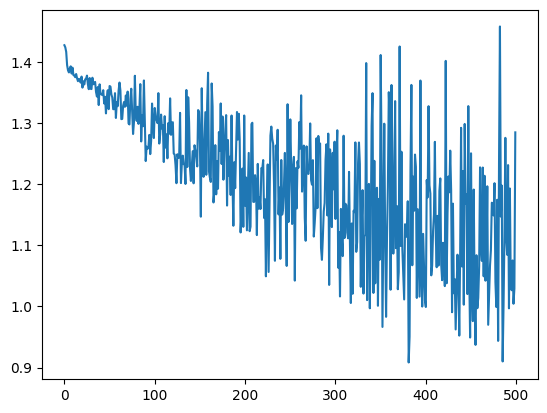

In [33]:
plt.plot(cost_func_store, label='Cost function value')

scalability

- scalingの実装開始、量子回路の深さ＆qubit数を増やすことを関数化
- gradientの変化文のスケールの変化を見る